In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Import all the tools we need


# Regular EDA(exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

def setup_data(df):
    '''
    Preprocess some basic works
    '''
    # Drop every column except the specified column
    df = df[['rating', 'review']]
    # Drop Null rows
    df = df[~(df == 'Null').any(axis=1)]
    
    
    return df

def remove_big_review(rev):
    '''
    Removes big review greter than length
    '''
    if len(rev)>3000:
        rev = 'Null'
    return rev

def clean_text(test):
    '''
    Clean's up the unnecessary thiings of a text by replacing them with proper symbols.
    '''
    test = test.replace('<br/>', '')
    test = test.replace('--', ' ')
    test = test.replace("'", '')
    test = test.replace('"','')
#     test = test.replace('.', '')
    test = test.replace(',', '')
#     test = test.replace('?', '')
#     test = test.replace('!', '')
    test = test.replace('\n', '')
    test = test.replace('(', '')
    test = test.replace(')', '')
    test = test.replace('..', ' ')
    test = test.replace('...', ' ')
    test = test.replace('</li></ul><ul><li>', ' ')
    test = test.lower()
    # Remove extra spaces
    test = ' '.join(test.split())

    return test


def level(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [10, 9]:
        x = 0
    elif x in [7, 6, 8]:
        x = 1
    elif x in [5, 4]:
        x = 2
    elif x in [1, 2, 3]:
        x = 3
    return x

def level2(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x > 5:
        x = 0
    else:
        x = 1
    return x

def plot_rate(df):
    df.label.value_counts().sort_index().plot(kind='bar', cmap='winter', 
                                              title='IMDb Rating');
    plt.xlabel('Ratings')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
data= pd.read_csv('/kaggle/input/movie-review/Joker 2019.csv')
data.head(3)

In [ ]:
data.sample()

In [ ]:
ri = np.random.randint(len(data))
print(data['rating'][ri])
data['review'][ri]

In [ ]:
data.shape
data.rating.value_counts().plot(kind='bar', cmap='winter', title='IMDb Rating');

-----

In [ ]:
df = data
df.review = df.review.apply(remove_big_review)
df = setup_data(df)
# df.shape
# Clean the text removing unnecessary things
df['review'] = df['review'].apply(clean_text)
df.rating = df.rating.astype(int)
data = df

In [ ]:
data.columns=['label','text']
plot_rate(data)

In [ ]:
print(data.shape)
data.head(2)

In [ ]:
ri = np.random.randint(len(data))
print(data['label'][ri])
data['text'][ri]

In [ ]:
data = data.drop(index=[row for row in data.index if  len(data.loc[row,'text'])<5])
data.shape

In [ ]:
data['Revlen'] = data.text.apply(lambda x: len(x))

In [ ]:
data.Revlen

In [ ]:
x = data['Revlen'].values

In [ ]:
sorted_array = np.sort(x)
sorted_array[:100]

In [ ]:
data.drop('Revlen', axis=1, inplace=True)

# Model S

In [ ]:
sdf = data.copy()
sdf.sample()

In [ ]:
sdf.label = sdf.label.apply(level2)
plot_rate(sdf)

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
train, test = train_test_split(sdf, test_size=0.2)
len(train), len(test)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

In [ ]:
train.to_csv('/kaggle/working/s_train.csv', index=False)
test.to_csv('/kaggle/working/s_test.csv', index=False)

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train':'/kaggle/working/s_train.csv',
                                              'test':'/kaggle/working/s_test.csv'})

In [ ]:
from transformers import BertTokenizer, TFBertModel,AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True,padding=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')
id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2

In [ ]:
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

In [ ]:
from transformers import TFAutoModelForSequenceClassification
modelS=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)

In [ ]:
tf_train_set = modelS.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelS.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
modelS.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
# Slice the dataset from length 100 to 10
sliced_dataset_train = tf_train_set.take(100)
sliced_dataset_test = tf_validation_set.take(100)

In [ ]:
modelS.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=2)

In [ ]:
training_accuracy = [.9429, .9751, .9895, .9953, .9962, .9978, .9978, .9982, .9977, .9981]
validation_accuracy = [.9311, .9337, .9285, .9228, .9291, .9234, .9342, .9301, .9291, .9239]

In [ ]:
training_loss = [.1511, .0751, .0326, .0147, .0135, .0076, .0081, .0075, .0078, .0059]
validation_loss = [.1824, .2322, .2770, .3262, .3253, .5142, .3520, .3399, .2338, .4937]

In [ ]:
epochs = range(1, len(training_accuracy) + 1)

# Plotting training accuracy and validation accuracy
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim([0.8, 1])
plt.show()


In [ ]:
# Plotting training loss and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [ ]:
test.head(2)

In [ ]:
plot_rate(test)

In [ ]:
true = list(test[:100].label)
test_text = list(test[:100].text)

In [ ]:
def custom_test(text, model):
    '''
    Test your model in a custom text
    '''
    inputs=tokenizer(text,return_tensors="tf")
    tf_outputs = model(inputs)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1) 
    # print(tf_predictions)
    logits=modelS(**inputs).logits
    # print("Logits :",logits)
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    return predicted_class_id

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn import metrics

preds = []
for text in tqdm(test_text):
    preds.append(custom_test(text, modelS))


con_mat = confusion_matrix(true, preds)
con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score


# Calculate accuracy score
accuracy = accuracy_score(true, preds)

print(f"Accuracy: {accuracy*100:.2f}%", )

In [ ]:
 # Create a new TensorBoard session everytime we train a model
tensorboard = tensorboard_callbacks()
# Create a early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)
# Fit the model to the data  passing it the callbacks we created
model.fit(x=train_data, 
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

# ModelUP

In [ ]:
udf = data.copy()
udf = udf[udf['label'] > 5].copy()

In [ ]:
print(udf.shape)
plot_rate(udf)

In [ ]:
def level_up(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [10, 9]:
        x = 0
    elif x in [7, 6, 8]:
        x = 1
    return x

In [ ]:
udf['label'] = udf['label'].apply(level_up)
plot_rate(udf)

In [ ]:
def drop_ten(n, df):
    
    for i in range(n):
        ind_to_drop = np.random.randint(1,len(df))
        try:
            if df.label[ind_to_drop] == 0:
                df = df.drop(ind_to_drop)
        except:
            continue
    return df

In [ ]:
udf = udf.reset_index(drop=True)
udf.head()

In [ ]:
udf = drop_ten(2000, udf)
plot_rate(udf)

In [ ]:
np.random.seed(42)
train, test = train_test_split(udf, test_size=0.2)
len(train), len(test)

In [ ]:
plot_rate(train)

In [ ]:
plot_rate(test)

In [ ]:
train.to_csv('/kaggle/working/up_train.csv', index=False)
test.to_csv('/kaggle/working/up_test.csv', index=False)

In [ ]:
dataset = load_dataset('csv', data_files={'train':'/kaggle/working/up_train.csv',
                                              'test':'/kaggle/working/up_test.csv'})

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

In [ ]:
modelUP=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)
tf_train_set = modelUP.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelUP.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
modelUP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
modelUP.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=2)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
true = list(test[:100].label)
test_text = list(test[:100].text)

predup = []
for text in tqdm(test_text):
    predup.append(custom_test(text, modelUP))
    
con_mat = confusion_matrix(true, predup)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

# Model Down

In [ ]:
ddf = data[data['label'] <= 5].copy()
ddf.label.value_counts()

In [ ]:
plot_rate(ddf)

In [ ]:
def level_down(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [4, 5]:
        x = 0
    elif x in [1, 2, 3]:
        x = 1
    return x

In [ ]:
ddf['label'] = ddf['label'].apply(level_down)
plot_rate(ddf)


In [ ]:
np.random.seed(42)
train, test = train_test_split(ddf, test_size=0.2)
len(train), len(test)

In [ ]:
train.to_csv('/kaggle/working/d_train.csv', index=False)
test.to_csv('/kaggle/working/d_test.csv', index=False)

In [ ]:
plot_rate(train)

In [ ]:
plot_rate(test)

In [ ]:
dataset = load_dataset('csv', data_files={'train':'/kaggle/working/d_train.csv',
                                              'test':'/kaggle/working/d_test.csv'})

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

In [ ]:
modelDN=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)
tf_train_set = modelDN.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelDN.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
modelDN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
modelDN.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=2)

In [ ]:
true = list(test[:100].label)
test_text = list(test[:100].text)

preddn = []
for text in test_text:
    preddn.append(custom_test(text, modelDN))
    
con_mat = confusion_matrix(true, preddn)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

# final

In [ ]:
ft = data.copy()

In [ ]:
ft.head(2)

In [ ]:
ft.label = ft.label.apply(level)

In [ ]:
plot_rate(ft)

In [ ]:
np.random.seed(42)
train, test = train_test_split(ft, test_size=0.2)
len(train), len(test)

In [ ]:
def final_prediction(text):
    '''
    Implements our awsome algorithm and gives final output
    '''
    inputs=tokenizer(text,return_tensors="tf")
    tf_outputs = modelS(inputs)                                  
    tf_predictions =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) )
   
    if tf_predictions==0:
        tf_outputs = modelUP(inputs)                                  
        tf_predictions_final =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) ) 
        
    else:
        tf_outputs = modelDN(inputs)                                  
        tf_predictions_final =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) )+2
         
    return tf_predictions_final

In [ ]:
n = 200
true = list(test.label)
test_text = list(test.text)

In [ ]:
prediction = []
for text in tqdm(test_text):
    prediction.append(final_prediction(text))

In [ ]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(true, prediction)

print(f"Accuracy: {accuracy*100:.2f}%", )

## Custom data

In [113]:
# Create the data for the DataFrame
cdata = {
    'Rating': [0, 0, 0, 1, 0, 0, 2, 3, 3, 2],
    'Review': ["Absolutely loved it!",
               "Great movie, highly recommended.", 
               "A compelling and intense film.", 
               "Good, but could have been better.", 
               "A masterpiece of storytelling.",
              '''Joker is a truly remarkable film that takes us 
              on a journey into the origins of a legendary villain.
              With Joaquin Phoenix's captivating performance and 
              a thought-provoking storyline, Joker is a dark and intense
              exploration of the human mind. It breaks free from traditional
              superhero movies, leaving a lasting impression that will keep you
              thinking long after the movie ends.
              Don't miss this extraordinary cinematic experience.''',
              '''Joker falls short of its high expectations,
              leaving much to be desired. While Joaquin Phoenix delivers a committed
              performance, the film's storyline feels convoluted and lacking in depth.
              The dark and gritty atmosphere often overshadows any meaningful narrative,
              resulting in a confusing and disjointed viewing experience. Despite moments of 
              intensity, Joker fails to deliver a cohesive story or compelling character
              development. It's a missed opportunity to truly explore the depths of 
              this iconic character.''',
               '''
               Joker is an absolute disappointment, 
               failing on almost every level. Despite the hype surrounding 
               Joaquin Phoenix's performance, it cannot salvage this mess of a film. 
               The storyline is a convoluted mess, lacking coherence and purpose. 
               The attempt to delve into the character's psyche falls flat, 
               resulting in a shallow portrayal that leaves the audience perplexed and
               disengaged. The excessive darkness and violence serve no purpose other than
               shock value, adding to the overall unpleasant viewing experience. Joker is a 
               perfect example of style over substance, ultimately failing to deliver any 
               meaningful or thought-provoking content. 
               Save yourself the agony and skip this trainwreck of a film.
               ''',
               '''
               Joker (2019) is an absolute trainwreck that fails to live up to its potential. 
               Joaquin Phoenix's performance, while committed, cannot salvage this mess of a film.
               The storyline is a convoluted mess, lacking any coherence or substance. Instead of 
               exploring the complexities of the character, the film relies on shock value and 
               gratuitous violence, leaving the audience feeling repulsed rather than engaged. 
               The attempts at social commentary fall flat, coming across as pretentious and forced. 
               Joker is a prime example of style over substance, sacrificing narrative cohesion for
               a misguided attempt at artistic expression. 
               Save yourself the agony and avoid this cringe-worthy disaster of a film.
               ''',
               
               '''
               Joker (2019) is a movie that didn't quite live up to its hype. 
               Despite Joaquin Phoenix's efforts, the story didn't hold my attention 
               or make much sense.It was good but not that good. The social messages it tried 
               to convey felt forced and heavy-handed, lacking subtlety. 
               Overall, Joker was a letdown that didn't deliver a satisfying or coherent experience.
               '''
              ]
}
cdata =  pd.DataFrame(cdata)
cdata.Review = cdata.Review.apply(clean_text)
cdata

,Rating,Review
0,0,absolutely loved it!
1,0,great movie highly recommended.
2,0,a compelling and intense film.
3,1,good but could have been better.
4,0,a masterpiece of storytelling.
5,0,joker is a truly remarkable film that takes us...
6,2,joker falls short of its high expectations lea...
7,3,joker is an absolute disappointment failing on...
8,3,joker 2019 is an absolute trainwreck that fail...
9,2,joker 2019 is a movie that didnt quite live up...


In [114]:
true = list(cdata.Rating)
test_text = list(cdata.Review)

In [115]:
pred = []
for text in tqdm(test_text):
    pred.append(final_prediction(text))

100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


In [116]:
pred

[0, 0, 0, 1, 0, 0, 1, 3, 3, 2]

In [117]:
true

[0, 0, 0, 1, 0, 0, 2, 3, 3, 2]

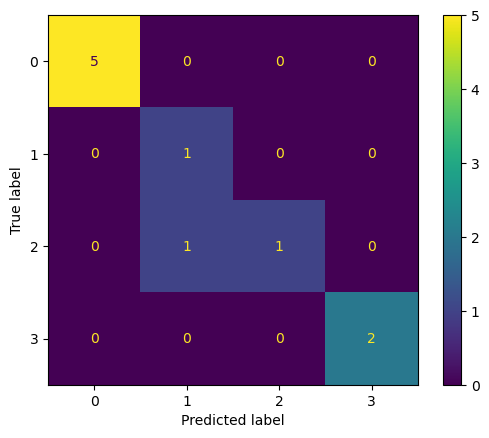

In [118]:
con_mat = confusion_matrix(true, pred)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

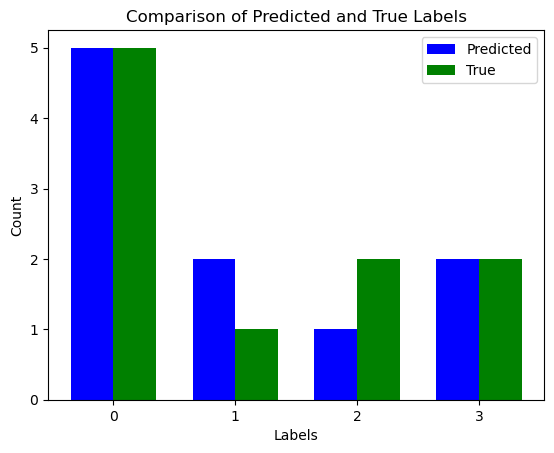

In [121]:
import matplotlib.pyplot as plt
import numpy as np

pred = [0, 0, 0, 1, 0, 0, 1, 3, 3, 2]
true = [0, 0, 0, 1, 0, 0, 2, 3, 3, 2]

# Count the occurrences of each value in the pred and true arrays
pred_counts = np.bincount(pred)
true_counts = np.bincount(true)

# Get the unique labels from both arrays
labels = np.unique(np.concatenate((pred, true)))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(pred_counts))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.bar(r1, pred_counts, color='blue', width=bar_width, label='Predicted')
plt.bar(r2, true_counts, color='green', width=bar_width, label='True')

# Add labels, title, and legend
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Comparison of Predicted and True Labels')
plt.xticks([r + bar_width / 2 for r in range(len(labels))], labels)
plt.legend()

# Show the plot
plt.show()


## Test on WebScraped data 

In [ ]:
wdf = pd.read_csv('/kaggle/input/movie-review/joker_reviews-2.csv')
wdf.head(2)

In [ ]:
wdf['label'] = wdf['Rating']
wdf['text'] = wdf['Review']

In [ ]:
wdf.drop(['Review', 'Rating'], axis=1, inplace=True)
wdf.head(2)

In [ ]:
wdf.label.value_counts()
level()

In [ ]:
wdf.label = wdf.label.apply(level)
plot_rate(wdf)

In [ ]:
wdf.text = wdf.text.apply(clean_text)

In [ ]:
wdf.text[100]

In [ ]:
wdf.head(2)

In [ ]:
np.random.seed(71)
train, test = train_test_split(wdf, test_size=0.2)
len(train), len(test)

In [ ]:
plot_rate(train)

In [ ]:
n = 200
true = list(train[:100].label)
test_text = list(train[:100].text)

In [ ]:
prediction = []
for text in tqdm(test_text):
    prediction.append(final_prediction(text))

In [ ]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat,
                                              display_labels=[0,1, 2])
con_mat_plot.plot()
plt.show()

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(true, prediction)

print(f"Accuracy: {accuracy*100:.2f}%", )

## Recent Reviews

In [ ]:
rdf = pd.read_csv('/kaggle/input/movie-review/joker_reviews-recent.csv')
rdf.head(2)

In [ ]:
rdf['label'] = rdf['Rating']
rdf['text'] = rdf['Review']
rdf.drop(['Review', 'Rating'], axis=1, inplace=True)
rdf.head(2)

In [ ]:
plot_rate(rdf)

In [ ]:
rdf.label = rdf.label.apply(level)
plot_rate(rdf)

In [ ]:
rdf.text = rdf.text.apply(clean_text)

In [ ]:
random_index = np.random.randint(len(rdf))
rdf.text[random_index]

In [ ]:
np.random.seed(71)
train, test = train_test_split(rdf, test_size=0.2)
len(train), len(test)

In [ ]:
n = 2000
true = list(rdf[:n].label)
test_text = list(rdf[:n].text)

In [ ]:
prediction = []
for text in tqdm(test_text):
    prediction.append(final_prediction(text))

In [ ]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat,
                                              display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(true, prediction)

print(f"Accuracy: {accuracy*100:.2f}%", )

## recent 3 by nannu

In [ ]:
rdf = pd.read_csv('/kaggle/input/movie-review/joker_reviews_train.csv')
rdf.head(2)
rdf['label'] = rdf['Rating']
rdf['text'] = rdf['Review']
rdf.drop(['Review', 'Rating'], axis=1, inplace=True)
rdf.head(2)
plot_rate(rdf)
rdf.label = rdf.label.apply(level)
plot_rate(rdf)

In [ ]:
rdf.text = rdf.text.apply(clean_text)

In [ ]:
random_index = np.random.randint(len(rdf))
rdf.text[random_index]

In [ ]:
np.random.seed(71)
train, test = train_test_split(rdf, test_size=0.2)
len(train), len(test)

In [ ]:
plot_rate(test)

In [ ]:
n = 2000
true = list(test[:n].label)
test_text = list(test[:n].text)
prediction = []
for text in tqdm(test_text):
    prediction.append(final_prediction(text))
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat,
                                              display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()